In [26]:
import torch
from torch import nn
from matplotlib import pyplot as plt

In [7]:
r = 10
c = 8
embed = 5
batch = 1
heads = 4
matrix = torch.rand(batch, r, c)
matrix

tensor([[[0.7528, 0.8536, 0.5633, 0.9941, 0.1558, 0.2721, 0.4401, 0.4514],
         [0.3017, 0.2350, 0.4343, 0.5517, 0.3288, 0.4388, 0.2325, 0.1349],
         [0.5952, 0.6071, 0.0752, 0.7441, 0.0278, 0.5404, 0.7307, 0.9666],
         [0.2400, 0.3430, 0.6861, 0.4971, 0.0558, 0.1271, 0.1321, 0.4013],
         [0.6176, 0.1670, 0.0846, 0.4180, 0.6585, 0.7640, 0.2097, 0.0847],
         [0.5855, 0.7225, 0.2919, 0.6298, 0.8147, 0.3194, 0.3121, 0.1431],
         [0.9406, 0.6665, 0.3215, 0.0135, 0.9781, 0.2643, 0.5602, 0.1463],
         [0.5693, 0.1535, 0.2021, 0.7632, 0.8355, 0.4895, 0.8008, 0.1235],
         [0.9445, 0.8945, 0.4015, 0.2353, 0.1407, 0.1480, 0.3856, 0.3654],
         [0.3680, 0.2438, 0.1298, 0.1814, 0.7778, 0.3533, 0.4496, 0.4691]]])

# 初始化矩阵

In [20]:
class multheads(nn.Module):
    def __init__(self, batch, r, c, embed, kqs, vs, heads ):
        super(multheads, self).__init__()
        self.batch = batch
        self.r = r
        self.c = c
        self.embed = embed
        self.kqs = kqs
        self.vs = vs
        self.heads = heads
        self.sum = r * c
        self.E = nn.Linear(1, embed)
        self.Q = nn.ModuleList([nn.Linear(embed, kqs) for _ in range(heads)])
        self.K = nn.ModuleList([nn.Linear(embed, kqs) for _ in range(heads)])
        self.V = nn.ModuleList([nn.Linear(embed, vs) for _ in range(heads)])
        self.O = nn.Linear(vs*heads, vs)
    
    
    def forward(self, X):
        X = X.reshape(batch, self.sum, 1)
        E = self.E(X)
        outputs = []
        
        for head in range(self.heads):
            Q = self.Q[head](E)
            K = self.K[head](E)
            V = self.V[head](E)
            A = torch.einsum('nqd, nkd -> nqk', [Q, K]) * (self.kqs ** (-0.5))
            A = nn.functional.softmax(A, dim = 2)
            # 得到注意力权重
            O = torch.einsum('nqd, ndk -> nqk', [A, V])
            # 得到这个头的输出
            outputs.append(O)
        
        all_out = torch.cat(outputs, dim = 2)
        final = self.O(all_out)
        return final

# 定义多头模型

In [21]:
my_mul = multheads(batch, r, c, embed, r*c, 1, heads)

In [22]:
Out = my_mul(matrix)

In [23]:
Out.shape

torch.Size([1, 80, 1])

In [27]:
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),
                  cmap='Reds'):
    """显示矩阵热图"""
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize,
                                 sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
            
    fig.colorbar(pcm, ax=axes, shrink=0.6)

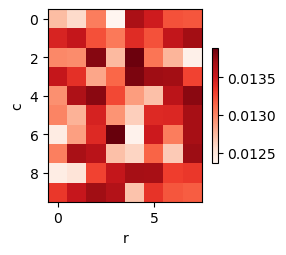

In [29]:
show_heatmaps(Out.reshape(1, 1, r, c), xlabel='r', ylabel='c')

# 现在我们定义一个多组模型

In [59]:
class multgroups(nn.Module):
    def __init__(self, batch, r, c, embed, kqs, vs, groups):
        super(multgroups, self).__init__()
        self.batch = batch
        self.r = r
        self.c = c
        self.embed = embed
        self.kqs = kqs
        self.vs = vs
        self.groups = groups
        self.sum = r * c
        self.E = nn.Linear(1, embed)
        self.Q = nn.ModuleList([nn.Linear(embed, kqs) for _ in range(groups)])
        self.K = nn.ModuleList([nn.Linear(embed, kqs) for _ in range(groups)])
        self.V = nn.ModuleList([nn.Linear(embed, vs) for _ in range(groups)])
        self.O = nn.Linear(vs*, vs)
    
    
    def forward(self, X):
        num_members = self.sum / groups
        X = X.reshape(batch, self.sum, 1)
        E = self.E(X)
        
        outputs = []
        
        for group in range(self.groups):
            for i in range(int(num_members)):
                Q = self.Q[group](E)
                K = self.K[group](E)
                V = self.V[group](E)
                A = torch.einsum('nqd, nkd -> nqk', [Q, K]) * (self.kqs ** (-0.5))
                A = nn.functional.softmax(A, dim = 2)
                # 得到注意力权重
                O = torch.einsum('nqd, ndk -> nqk', [A, V])
                # 得到这个头的输出
                outputs.append(O)

        all_out = torch.cat(outputs, dim = 2)
        print(all_out.shape)
        final = self.O(all_out)
        return final